### Q1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = stats.gamma(a= n/2 + 1, scale= 2/((x- theta[c, g-1])**2).sum()).rvs()
        theta[c,g] = stats.norm(loc= x.mean(), scale = 1/(tau[c,g] * n)**0.5).rvs()

We should explain the process of getting the posterior in previous code session(coing from Part C in lecture): 

$$\begin{align*}
\text{since}\; p(\theta,\tau) \propto 1 \;\text{and}\; p\left(x|\theta,\tau=\frac{1}{\sigma^2}\right) = {} & \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} \,exp(-\frac{\tau}{2}(x_i-\theta)^2) \\
\text{such that}\; p(\theta,\tau| x) \propto p(\theta,\tau, x) \propto {} &  \tau^{n/2} \,exp[-\frac{\tau}{2} \sum_{i=1}^n (x_i-\theta)^2] \\
p(\tau|\theta, x) = {} & \text{Gamma}\left(\alpha = \frac{n}{2}+1, \beta= \frac{1}{2} \sum_{i=1}^n (x_i-\theta)^2 \right)\\
p(\theta| \sigma^2 = \tau^{-1}, x) = {} & N\left(E[\theta] = \bar x, Var(\theta) = \frac{\sigma^2}{n}\right)
\end{align*}$$


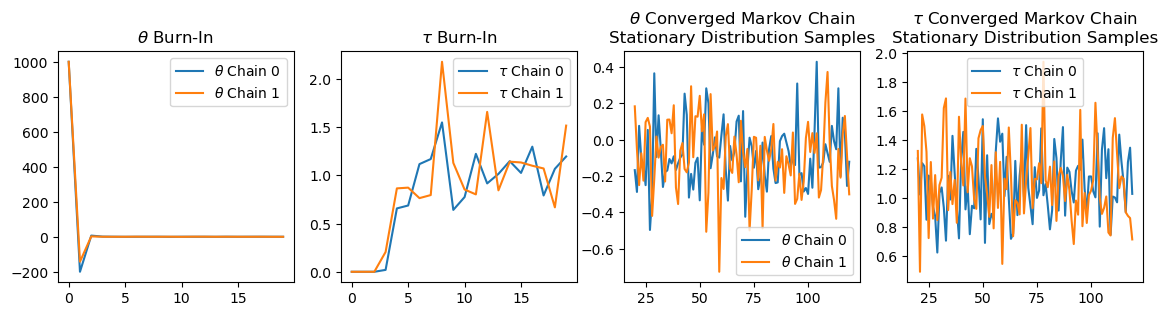

In [3]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); 
    ax[1].set_title("$\\tau$ Burn-In"); 
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); 
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

### Q2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau^2_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*

Given that prior $\theta$ ~ $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$.

$$
p \left(x|\theta,\tau \right) = \left(\frac{\tau}{2\pi}\right)^{\frac{n}{2}}\text{exp}\left(-\frac{\tau}{2}\sum_{i=1}^n(x_i-\theta)^2\right) \\
$$
By Bayesian theorem
$$
p(\tau|\theta, x) \propto p(x|\theta,\tau)p(\tau) \\
\propto \tau^{\frac{\alpha + n}{2}-1}\text{exp}\left(-\frac{\tau}{2}\left(\lambda + \sum_{i=1}^n(x_i-\theta)^2 \right) \right) \\
\tau | \theta, x \sim \text{Gamma} \left(\frac{\alpha + n}{2}, \frac{\lambda + \sum_{i=1}^n(x_i-\theta)^2}{2} \right) \\
$$
Similarly,
$$
p(\theta| \tau, x) \propto p(x|\theta,\tau)p(\theta|\tau) \\
\propto \text{exp} \left( -\frac{\tau}{2} \sum_{i=1}^n(x_i-\theta)^2 \right) \text{exp} \left( -\frac{\tau_0}{2} (\theta - \theta_0)^2 \right)\\
\propto \text{exp} \left( -\frac{n\tau + \tau_0}{2} \left( \theta - \frac{n\tau \bar{x} + \tau_0 \theta_0}{n\tau + \tau_0} \right)^2 \right) \\
\theta | \tau, x \sim N\left( \frac{n\tau \bar{x} + \tau_0 \theta_0}{n\tau + \tau_0}, \frac{1}{n\tau + \tau_0} \right)
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Given prior parameters
theta_0 = 0
tau_0 = 1
alpha = 2
lambda_ = 1

# Generate synthetic data
n = 30
x = np.random.normal(loc=5, scale=2, size=n)  # True mean=5, std=2

# Gibbs sampling settings
num_samples = 5000
theta_samples = np.zeros(num_samples)
tau_samples = np.zeros(num_samples)

# Initialize values
theta_samples[0] = np.mean(x)
tau_samples[0] = 1 / np.var(x)

# Gibbs sampling loop
for i in range(1, num_samples):
    # Sample tau from Gamma distribution
    sum_sq = np.sum((x - theta_samples[i-1])**2)
    tau_samples[i] = gamma.rvs(a=alpha/2 + n/2, scale=1/(lambda_/2 + sum_sq/2))

    # Sample theta from Normal distribution
    mean_theta = (n * np.mean(x) * tau_samples[i] + theta_0 * tau_0) / (n * tau_samples[i] + tau_0)
    var_theta = 1 / (n * tau_samples[i] + tau_0)
    theta_samples[i] = norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))

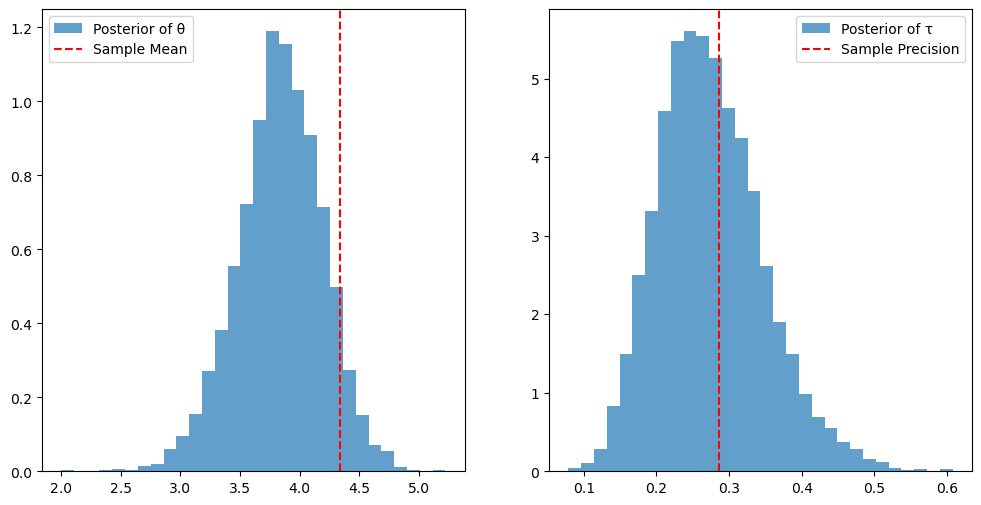

In [4]:
# Burn-in
burn_in = 1000
theta_post = theta_samples[burn_in:]
tau_post = tau_samples[burn_in:]

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(theta_post, bins=30, density=True, alpha=0.7, label='Posterior of θ')
plt.axvline(np.mean(x), color='r', linestyle='--', label='Sample Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(tau_post, bins=30, density=True, alpha=0.7, label='Posterior of τ')
plt.axvline(1/np.var(x), color='r', linestyle='--', label='Sample Precision')
plt.legend()
plt.show()


In perspective of "number of data points", prior hyper parameters can be seen as degree of strongness of prior belief, or weight to prior; so, the super parameters can be seen as prior number of data points. In detail, $\frac{\alpha}{2}$ is number of pseudo observations, and $\frac{\lambda}{2}$ is sum of squared deviation of prior belief.

### Q3

#### (A)
Following the structure of the resule, we can apply similar process on Multinomial-Dirchlet specification. \
Suppose we have the following model setup:

   \begin{align*}
    x_1,...,x_n &\overset{iid}{\sim} \text{Multinomial}(n, \theta)\\
    \theta = (\theta_1,\, ...\,,\theta_k)&\sim \text{Dirichlet}(\alpha_1,\, ...\,, \alpha_k)
    \end{align*}

So that we know the Likelihood function and Dirichlet prior:

   \begin{align*}
    p(x|\theta) = \frac{n!}{x_1! \,... x_k!}\theta_1^{x_1} ...\, \theta_k^{x_k} \\
    p(\theta) = \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)} 
    \theta_1^{\alpha_1-1} ...\, \theta_k^{\alpha_k - 1}
    \end{align*}

Since the prior follows a proper distribution, by Bayes' Theorem, we have the posterior:

   \begin{align*}
    p(\theta | x) &= \frac{p(\mathbf{x} | \theta)p(\theta)}{p(\mathbf{x})} \\
    &= \frac{p(\mathbf{x}| \theta)p(\theta)}{\int p(\mathbf{x} | \theta )p(\theta) d\theta}
    \end{align*}

Following the "converstation", we shall calculate $\int p(\mathbf{x} | \theta )p(\theta) d\theta$:

   \begin{align*}
    \int p(\mathbf{x} | \theta )p(\theta) d\theta &= \int \left( 
    \frac{n!}{x_1! \,... x_k!}\theta_1^{x_1} ...\, \theta_k^{x_k}\right)\left( 
    \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)} 
    \theta_1^{\alpha_1-1} ...\, \theta_k^{\alpha_k - 1}\right) d\theta \\
    &= \frac{n!}{x_1! \,... x_k!} \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)}
    \int \theta_1^{x_1 + \alpha_1 - 1} ...\, \theta_k^{x_k + \alpha_k - 1} d\theta \\
    &\text{By Dirichlet distribution integral formula} \\
    &= \frac{n!}{x_1! \,... x_k!} \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)}
    \frac{\prod^k_{i=1}\Gamma(x_i + \alpha_i)} {\Gamma\left(n + \sum^k_{i=1} \alpha_i\right)} \\
    \end{align*}

Plug the result back to the posterior:

   \begin{align*}
    p(\theta | x) &=\frac{\frac{n!}{x_1! \,... x_k!}\theta_1^{x_1} ...\, \theta_k^{x_k}
        \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)} 
        \theta_1^{\alpha_1-1} ...\, \theta_k^{\alpha_k - 1}
    }
    {\frac{n!}{x_1! \,... x_k!} 
        \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)}
        \frac{\prod^k_{i=1}\Gamma(x_i + \alpha_i)} {\Gamma\left(n + \sum^k_{i=1} \alpha_i\right)}
    } \\
    &= \frac{\Gamma\left(n + \sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(x_i + \alpha_i)}
        \theta_1^{x_1 + \alpha_1 - 1} ...\, \theta_k^{x_k + \alpha_k - 1} \\
    &\text{This follows a Dirchlet distribution} \\
    \theta | x &\sim \text{Dirichlet}(x_1 + \alpha_1,\,...\,,x_k + \alpha_k)\\
    \end{align*}
    
Alternatively, if we observe the joint:
   \begin{align*}
    p(\mathbf{x} | \theta)p(\theta) &= \frac{n!}{x_1! \,... x_k!}\theta_1^{x_1} ...\, \theta_k^{x_k}
        \frac{\Gamma\left(\sum^k_{i=1} \alpha_i\right)}{\prod^k_{i=1}\Gamma(\alpha_i)} 
        \theta_1^{\alpha_1-1} ...\, \theta_k^{\alpha_k - 1} \\
    &\propto \theta_1^{x_1 + \alpha_1 - 1} ...\, \theta_k^{x_k + \alpha_k - 1}
    \end{align*}
Such that, the joint is proportional to the posterior.